In [4]:
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [5]:
df = pd.read_csv("./Train.csv")
df.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [6]:
print(df.shape)

(6034195, 4)


In [7]:
df = df.iloc[:10000, :]
print("Shape of dataframe after subsetting : ",df.shape)

Shape of dataframe after subsetting :  (10000, 4)


In [8]:
duplicate_pairs = df.sort_values('Title', ascending=False).duplicated('Title')
print("Total no. of duplicate questions: ", duplicate_pairs.sum())
df = df[~duplicate_pairs]
print("Dataframe shape after duplicate removal: ",df.shape)

Total no. of duplicate questions:  4
Dataframe shape after duplicate removal:  (9996, 4)


In [9]:
df["tag_count"] = df["Tags"].apply(lambda x: len(x.split()))

In [10]:
df["tag_count"].value_counts()

3    2919
2    2612
4    1969
1    1296
5    1200
Name: tag_count, dtype: int64

In [11]:
print("Avg no. of tags in a question: ",df["tag_count"].mean())

Avg no. of tags in a question:  2.916466586634654


Text(0, 0.5, 'Frequency')

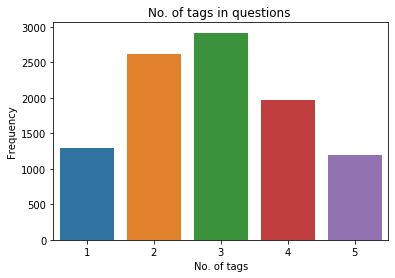

In [12]:
sns.countplot(df["tag_count"])
plt.title("No. of tags in questions ")
plt.xlabel("No. of tags")
plt.ylabel("Frequency")

In [13]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_bow = vectorizer.fit_transform(df['Tags'])

In [14]:
print("No. of questions: ",tag_bow.shape[0])
print("No. of unique tags: ",tag_bow.shape[1])

No. of questions:  9996
No. of unique tags:  6124


In [15]:
tags = vectorizer.get_feature_names()
print("Few tags: ",tags[:10])

Few tags:  ['.htaccess', '.net', '.net-2.0', '.net-3.5', '.net-4.0', '.net-4.5', '.net-assembly', '.net-framework', '.net4.0', '.refresh']


In [16]:
freq = tag_bow.sum(axis=0).A1
tag_to_count_map = dict(zip(tags, freq))

list = []
for key, value in tag_to_count_map.items():
    list.append([key, value])

In [17]:
tag_df = pd.DataFrame(list, columns=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.htaccess,40
1,.net,302
2,.net-2.0,6
3,.net-3.5,7
4,.net-4.0,10


Text(0, 0.5, 'Frequency')

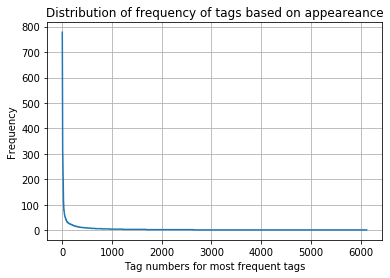

In [18]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
plt.plot(tag_df_sorted['Counts'].values)
plt.grid()
plt.title("Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

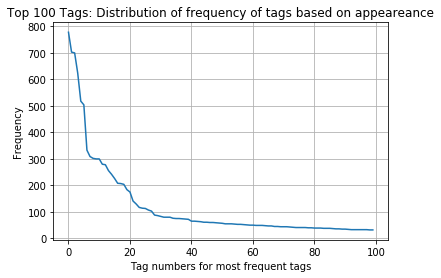

In [19]:
plt.plot(tag_df_sorted['Counts'][0:100].values)
plt.grid()
plt.title("Top 100 Tags: Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

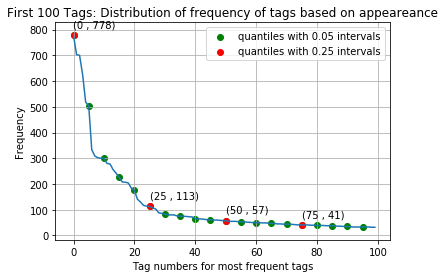

In [20]:
plt.plot(tag_df_sorted['Counts'][0:100].values)
plt.scatter(x=np.arange(0,100,5), y=tag_df_sorted['Counts'][0:100:5], c = 'g', label = "quantiles with 0.05 intervals")
plt.scatter(x=np.arange(0,100,25), y=tag_df_sorted['Counts'][0:100:25], c = 'r', label = "quantiles with 0.25 intervals")
for x,y in zip(np.arange(0,100,25), tag_df_sorted['Counts'][0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy = (x,y), xytext=(x-0.01, y+30))
plt.grid()
plt.title("First 100 Tags: Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")
plt.legend()

In [21]:
print("{} tags are used more than 25 times".format(tag_df_sorted[tag_df_sorted["Counts"]>25].shape[0]))
print("{} tags are used more than 50 times".format(tag_df_sorted[tag_df_sorted["Counts"]>50].shape[0]))

144 tags are used more than 25 times
59 tags are used more than 50 times


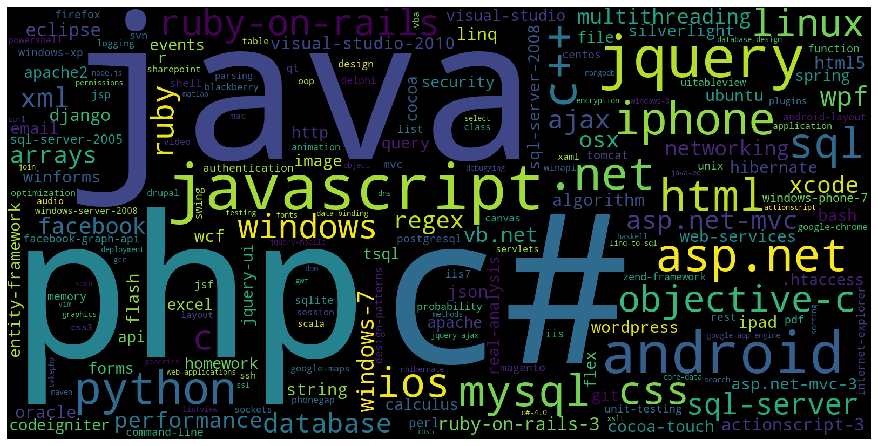

In [22]:
#word map for most frequent tags
tag_to_count_map
tup1 = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600,height=800,).generate_from_frequencies(tup1)
plt.figure(figsize = (12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

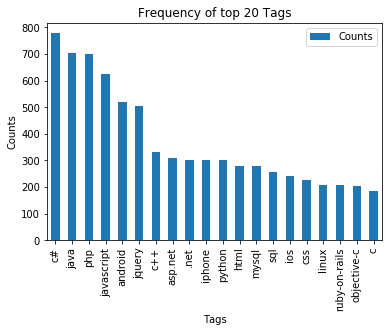

In [27]:
#bar plot of top 20 tags
i=np.arange(20)
tag_df_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 Tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [30]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [32]:
qus_list=[]
qus_with_code = 0
len_before_preprocessing = 0
len_after_preprocessing = 0
for index,row in df.iterrows():
    title, body, tags = row["Title"], row["Body"], row["Tags"]
    if '<code>' in body:
        qus_with_code+=1
    len_before_preprocessing+=len(title) + len(body)
    body = re.sub('<code>(.*?)</code>', '',body, flags = re.MULTILINE|re.DOTALL)
    body = re.sub('<.*?>', ' ', str(body.encode('utf-8')))
    title = title.encode('utf-8')
    question = str(title)+" "+str(body)
    question = re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    qus_list.append(question)
    len_after_preprocessing += len(question)
df["question"]=qus_list
avg_len_before_preprocessing=(len_before_preprocessing*1.0)/df.shape[0]
avg_len_after_preprocessing=(len_after_preprocessing*1.0)/df.shape[0]
print("Avg len of questions before preprocessing: ",avg_len_before_preprocessing)
print("Avg len of questions after preprocessing: ",avg_len_after_preprocessing)
print("% of questions containing code: ",(qus_with_code*100.0)/df.shape[0])

Avg len of questions before preprocessing:  1158.4714885954381
Avg len of questions after preprocessing:  329.35994397759106
% of questions containing code:  55.88235294117647


In [33]:
preprocessed_df = df[["question","Tags"]]
print("Shape of Preprocessed data : ",preprocessed_df.shape)

Shape of Preprocessed data :  (9996, 2)


In [34]:
# Machine Learning Models
# Multilabel problem - Handling Tags

vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
y_multilabel = vectorizer.fit_transform(preprocessed_df['Tags'])

In [35]:
def tags_to_consider(n):
    tag_i_sum = y_multilabel.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(tag_i_sum)), key = lambda i: tag_i_sum[i], reverse=True)
    yn_multilabel=y_multilabel[:,sorted_tags_i[:n]]
    return yn_multilabel

def questions_covered_fn(numb):
    yn_multilabel = tags_to_consider(numb)
    x = yn_multilabel.sum(axis=1)
    return (np.count_nonzero(x==0))

In [36]:
questions_covered = []
total_tags=y_multilabel.shape[1]
total_qus=preprocessed_df.shape[0]
for i in range(100, total_tags, 100):
    questions_covered.append(np.round(((total_qus-questions_covered_fn(i))/total_qus)*100,3))

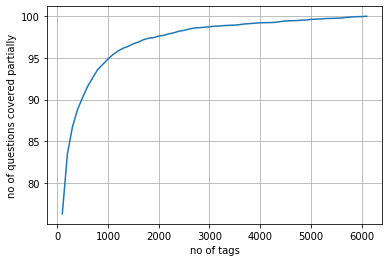

94.848 % of questions covered by 1000 tags
No of questions that are not covered by 1000 tags :  515 out of  9996


In [37]:
plt.plot(np.arange(100, total_tags,100), questions_covered)
plt.xlabel("no of tags")
plt.ylabel("no of questions covered partially")
plt.grid()
plt.show()
print(questions_covered[9],"% of questions covered by 1000 tags")
print("No of questions that are not covered by 1000 tags : ", questions_covered_fn(1000),"out of ",total_qus)

In [38]:
yx_multilabel = tags_to_consider(1000)
print("No of tags in the subset : ", y_multilabel.shape[1])
print("No of tags considered : ",yx_multilabel.shape[1], "(",(yx_multilabel.shape[1]/y_multilabel.shape[1])*100,"%)")

No of tags in the subset :  6124
No of tags considered :  1000 ( 16.32919660352711 %)


In [39]:
# Splitting into train and test set with 80:20 ratio

X_train, X_test, y_train, y_test = train_test_split(preprocessed_df, yx_multilabel, test_size = 0.2, random_state = 42)
print("No. of data points in training data: ", X_train.shape[0])
print("No. of data points in test data: ", X_test.shape[0])

No. of data points in training data:  7996
No. of data points in test data:  2000


In [40]:
# Featurization of training data 

vectorizer = TfidfVectorizer(min_df=0.00009, max_features = 200000, tokenizer = lambda x: x.split(), ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train['question'])
X_test_multilabel = vectorizer.transform(X_test['question'])

In [41]:
print("Training data shape X : ",X_train_multilabel.shape, "Y :", y_train.shape)
print("Test data shape X : ",X_test_multilabel.shape, "Y :", y_test.shape)

Training data shape X :  (7996, 200000) Y : (7996, 1000)
Test data shape X :  (2000, 200000) Y : (2000, 1000)


In [44]:
# Fitting Logistic Regression with OneVsRest Classifier

clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2'))
clf.fit(X_train_multilabel, y_train)
y_pred = clf.predict(X_test_multilabel)

In [45]:
print("Accuracy : ",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score : ",metrics.f1_score(y_test,y_pred, average='macro'))
print("Micro f1 score : ",metrics.f1_score(y_test,y_pred, average='micro'))
print("Hamming Loss : ",metrics.hamming_loss(y_test,y_pred))

Accuracy :  0.101
Macro f1 score :  0.034653112292550546
Micro f1 score :  0.2658347513707695
Hamming Loss :  0.0019415


In [53]:
# Modelling by assigning more weightage to Title

qus_list=[]
qus_with_code = 0
len_before_preprocessing = 0
len_after_preprocessing = 0
for index,row in df.iterrows():
    title, body, tags = row["Title"], row["Body"], row["Tags"]
    if '<code>' in body:
        qus_with_code+=1
    len_before_preprocessing+=len(title) + len(body)
    body = re.sub('<code>(.*?)</code>', '',body, flags = re.MULTILINE|re.DOTALL)
    body = re.sub('<.*?>', ' ', str(body.encode('utf-8')))
    title = title.encode('utf-8')
    question = str(title)+" "+str(title)+" "+str(title)+" "+str(body)
    question = re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    qus_list.append(question)
    len_after_preprocessing += len(question)
df["question_with_more_wt_title"]=qus_list
avg_len_before_preprocessing=(len_before_preprocessing*1.0)/df.shape[0]
avg_len_after_preprocessing=(len_after_preprocessing*1.0)/df.shape[0]
print("Avg len of questions before preprocessing: ",avg_len_before_preprocessing)
print("Avg len of questions after preprocessing: ",avg_len_after_preprocessing)
print("% of questions containing code: ",(qus_with_code*100.0)/df.shape[0])

Avg len of questions before preprocessing:  1158.4714885954381
Avg len of questions after preprocessing:  400.24249699879954
% of questions containing code:  55.88235294117647


In [54]:
preprocessed_df = df[["question_with_more_wt_title","Tags"]]
print("Shape of Preprocessed data : ",preprocessed_df.shape)

Shape of Preprocessed data :  (9996, 2)


In [55]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_df, yx_multilabel, test_size = 0.2,random_state = 42)
print("Number of data points in training data :", X_train.shape[0])
print("Number of data points in test data :", X_test.shape[0])

# Featurization of training data 

vectorizer = TfidfVectorizer(min_df=0.00009, max_features = 200000, tokenizer = lambda x: x.split(), ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train['question_with_more_wt_title'])
X_test_multilabel = vectorizer.transform(X_test['question_with_more_wt_title'])

Number of data points in training data : 7996
Number of data points in test data : 2000


In [56]:
print("Training data shape X : ",X_train_multilabel.shape, "Y :", y_train.shape)
print("Test data shape X : ",X_test_multilabel.shape, "Y :", y_test.shape)

Training data shape X :  (7996, 200000) Y : (7996, 1000)
Test data shape X :  (2000, 200000) Y : (2000, 1000)


In [57]:
clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2'))
clf.fit(X_train_multilabel, y_train)
y_pred = clf.predict(X_test_multilabel)

In [62]:
print("Accuracy : ",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score : ",metrics.f1_score(y_test,y_pred, average='macro'))
print("Micro f1 score : ",metrics.f1_score(y_test,y_pred, average='micro'))
print("Hamming Loss : ",metrics.hamming_loss(y_test,y_pred))

Accuracy :  0.109
Macro f1 score :  0.047992392442814495
Micro f1 score :  0.3128834355828221
Hamming Loss :  0.001904


In [63]:
# using direct implementation of Logistic Regression

clf2 = OneVsRestClassifier(LogisticRegression(penalty='l1'))
clf2.fit(X_train_multilabel, y_train)
y_pred2 = clf2.predict(X_test_multilabel)

In [64]:
print("Accuracy : ",metrics.accuracy_score(y_test,y_pred2))
print("Macro f1 score : ",metrics.f1_score(y_test,y_pred2, average='macro'))
print("Micro f1 score : ",metrics.f1_score(y_test,y_pred2, average='micro'))
print("Hamming Loss : ",metrics.hamming_loss(y_test,y_pred2))

Accuracy :  0.1265
Macro f1 score :  0.14715244248444798
Micro f1 score :  0.4012364760432766
Hamming Loss :  0.001937
